In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Add braintumor_ddpm to path
sys.path.append(os.path.dirname(os.getcwd()))

from braintumor_ddpm.utils.data import scale_features
from braintumor_ddpm.data.datasets import SegmentationDataset
from braintumor_ddpm.utils.helpers import get_feature_clusters
from braintumor_ddpm.insights.representations import FeatureExtractorDDPM
from braintumor_ddpm.diffusion.config import brats_128x128_config

In [2]:
# Add corresponding paths
extracted_2d_data = r"PATH TO EXPORTED 2D SCANS"
trained_ddpm_path = r"PATH TO TRAINED MODEL"

# Datasets and Model
config = brats_128x128_config()

# Dataset (without scans)
data = SegmentationDataset(images_dir=extracted_2d_data,
                           masks_dir=None,
                           image_size=128,
                           verbose=False,
                           train=False)

# Extract representations
time_steps = [250, 1000, 2000, 3999]
layers = [14, 16, 18, 20, 22]

# Define feature extractor
feature_extractor = FeatureExtractorDDPM(model_path=trained_ddpm_path,
                                         steps=time_steps,
                                         blocks=layers,
                                         config=config)

Created segmentation dataset with 8757 items

Loaded pretrained diffusion model..


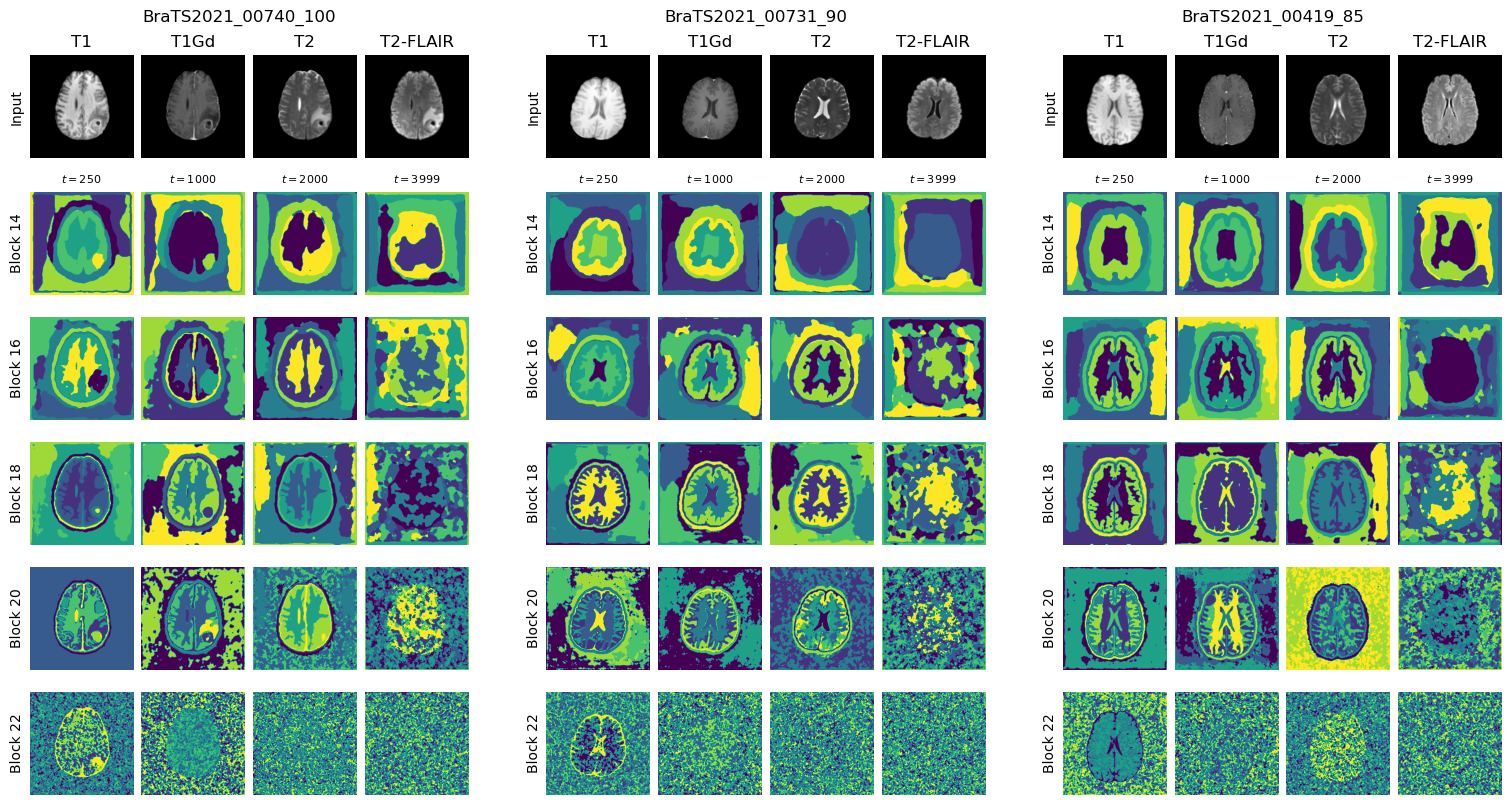

In [3]:
# Visualize samples
fig = plt.figure(layout='constrained', figsize=(15, 8))
subfigs = fig.subfigures(1, 3, wspace=0.1, hspace=0.05).ravel()
mr_sequences = ['T1', 'T1Gd', 'T2', 'T2-FLAIR']

for f in range(0, len(subfigs)):
    
    # Get sample scan, and set subfigure axes
    ax = subfigs[f].subplots(6, 4)
    random_idx = np.random.randint(low=0, high=8000)
    scan = train_data[random_idx]
    file_name = os.path.basename(train_data.dataset[random_idx]['image']).split('.')[0]
    features = feature_extractor(scan.cuda())
    
    # Set subfigure title
    subfigs[f].suptitle(f"{file_name}")
    
    # Subfigure plot
    for row in range(0, 6):
        for col in range(0, 4):
            if row == 0:
                ax[row][col].imshow(scan[col, :, :], cmap='gray')
                ax[row][col].set_title(mr_sequences[col])
                if col == 0:
                    ax[row][col].set_ylabel("Input")
            else:
                block = features[time_steps[col]][layers[row - 1]]
                block = scale_features([block], 256)
                block = get_feature_clusters(block, 256)
                ax[row][col].imshow(block)
                if row == 1:
                    ax[row][col].set_title(f"$t={time_steps[col]}$", fontsize=8)
                if col == 0:
                    ax[row][col].set_ylabel(f"Block {layers[row - 1]}")
            ax[row][col].set_frame_on(False)
            ax[row][col].set_yticklabels([])
            ax[row][col].set_xticklabels([])
            ax[row][col].set_xticks([])
            ax[row][col].set_yticks([])
            
# # Save figure
# output_file = os.path.join(os.getcwd(), 'assets', 'representations.png')
# plt.savefig(fname=output_file, dpi=300)